In [1]:
import csv
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# DeepMoD stuff
from deepymod import DeepMoD
from deepymod.model.func_approx import NN, Siren
from deepymod.model.library import Library1D
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Clustering, Threshold
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic
# Setting cuda
#if torch.cuda.is_available():
#    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    
# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
V_2_2 = np.loadtxt('data/data_20_10/V1_V2/data_V2.csv', delimiter=',', skiprows=3)
V_2_3 = np.loadtxt('data/data_20_10/V1_V3/data_V3.csv', delimiter=',', skiprows=3)
V_2_4 = np.loadtxt('data/data_20_10/V1_V4/data_V4.csv', delimiter=',', skiprows=3)
V_2_5 = np.loadtxt('data/data_20_10/V1_V5/data_V5.csv', delimiter=',', skiprows=3)
V_2_6 = np.loadtxt('data/data_20_10/V1_V6/data_V6.csv', delimiter=',', skiprows=3)
V_2_7 = np.loadtxt('data/data_20_10/V1_V7/data_V7.csv', delimiter=',', skiprows=3)
V_2_8 = np.loadtxt('data/data_20_10/V1_V8/data_V8.csv', delimiter=',', skiprows=3)
V_2_9 = np.loadtxt('data/data_20_10/V1_V9/data_V9.csv', delimiter=',', skiprows=3)

In [6]:
delta_V = np.concatenate((V_2_2[:, 1:], V_2_3[:, 1:], V_2_4[:, 1:], V_2_5[:, 1:], V_2_6[:, 1:], V_2_7[:, 1:], V_2_8[:, 1:], V_2_9[:, 1:]), axis=1)

In [7]:
upper_lim = 3000 
lower_lim = 540 

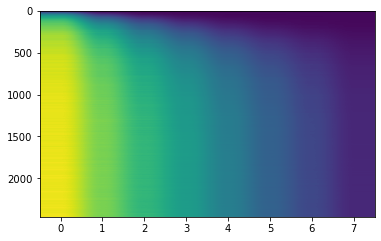

In [8]:
plt.figure(figsize=(6, 6))
plt.imshow(delta_V[lower_lim:upper_lim,:],aspect=0.002)

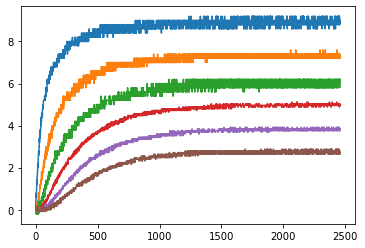

In [9]:
plt.figure(figsize=(6, 4))
plt.plot(V_2_2[540:3000, 1])
plt.plot(V_2_3[540:3000, 1])
plt.plot(V_2_4[540:3000, 1])
plt.plot(V_2_5[540:3000, 1])
plt.plot(V_2_6[540:3000, 1])
plt.plot(V_2_7[540:3000, 1])
#plt.plot(time, V2_4[:, 1])

In [10]:
output_data = delta_V[lower_lim:upper_lim,:].T
output_data.shape

(8, 2460)

In [11]:
x = np.linspace(0, 1, output_data.shape[0])
t = np.linspace(0, 1, output_data.shape[1])

In [12]:
x_grid, t_grid = np.meshgrid(x, t, indexing='ij')

In [13]:
X = np.transpose((t_grid.flatten(), x_grid.flatten()))
y = np.real(output_data).reshape((output_data.size, 1))
y = y/np.max(y)

In [14]:
number_of_samples = 5000

idx = np.random.permutation(y.shape[0])
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y[idx, :][:number_of_samples], dtype=torch.float32)

In [15]:
network = NN(2, [30, 30, 30, 30], 1)

Configuration of the library function: We select athe library with a 2D spatial input. Note that that the max differential order has been pre-determined here out of convinience. So, for poly_order 1 the library contains the following 12 terms:
* [$1, u_x, u_{xx}, u_{xxx}, u, u u_{x}, u u_{xx}, u u_{xxx}, u^2, u^2 u_{x}, u^2 u_{xx}, u^2 u_{xxx}$]

In [16]:
library = Library1D(poly_order=1, diff_order=2) 

Configuration of the sparsity estimator and sparsity scheduler used. In this case we use the most basic threshold-based Lasso estimator and a scheduler that asseses the validation loss after a given patience. If that value is smaller than 1e-5, the algorithm is converged.  

In [22]:
estimator = Threshold(0.025) 
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=10, delta=1e-5) 

Configuration of the sparsity estimator 

In [23]:
constraint = LeastSquares() 
# Configuration of the sparsity scheduler

Now we instantiate the model and select the optimizer 

In [24]:
model = DeepMoD(network, library, estimator, constraint)

In [25]:
# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=2e-3) 

## Run DeepMoD 

We can now run DeepMoD using all the options we have set and the training data:
* The directory where the tensorboard file is written (log_dir)
* The ratio of train/test set used (split)
* The maximum number of iterations performed (max_iterations)
* The absolute change in L1 norm considered converged (delta)
* The amount of epochs over which the absolute change in L1 norm is calculated (patience)

In [26]:
train(model, X_train, y_train, optimizer,sparsity_scheduler, log_dir='runs/test_5/', split=0.8, max_iterations=100000, delta=1e-7, patience=200) 

 17350  MSE: 1.59e-04  Reg: 2.40e-06  L1: 1.66e+00 

KeyboardInterrupt: 

In [27]:
print(model.estimator_coeffs())

[array([[ 0.        ],
       [ 0.        ],
       [ 1.1915287 ],
       [-0.46030414],
       [ 0.        ],
       [ 0.        ]], dtype=float32)]


In [28]:
sol = model(torch.tensor(X, dtype=torch.float32))[0].reshape(output_data.shape).detach().numpy()

In [29]:
sol.shape

(8, 2460)

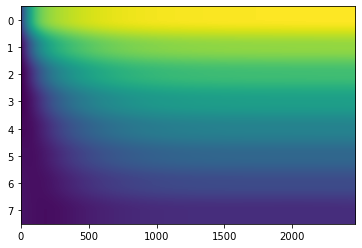

In [30]:
plt.imshow(sol, aspect = 200)

In [31]:
ux = model(torch.tensor(X, dtype=torch.float32))[2][0][:,1].reshape(output_data.shape).detach().numpy()
uxx = model(torch.tensor(X, dtype=torch.float32))[2][0][:,2].reshape(output_data.shape).detach().numpy()

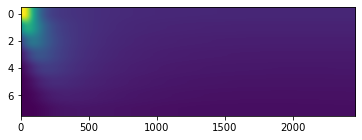

In [32]:
plt.imshow(uxx, aspect = 100)

In [33]:
import pysindy as ps

In [34]:
fd_spline = ps.SINDyDerivative(kind='spline', s=1e-2)
fd_spectral = ps.SINDyDerivative(kind='spectral')
fd_sg = ps.SINDyDerivative(kind='savitzky_golay', left=0.5, right=0.5, order=3)

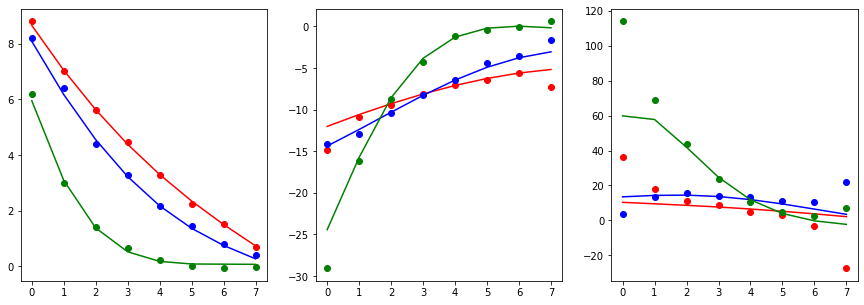

In [37]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3, 1)
plt.plot(output_data[:,800],'ro')
plt.plot(sol[:,800]*np.max(output_data),'r')
plt.plot(output_data[:,400],'bo')
plt.plot(sol[:,400]*np.max(output_data),'b')
plt.plot(output_data[:,100],'go')
plt.plot(sol[:,100]*np.max(output_data),'g')

plt.subplot(1,3, 2)
plt.plot(fd_sg(output_data[:,800],x),'ro')
plt.plot(ux[:,800]*np.max(output_data),'r')
plt.plot(fd_sg(output_data[:,400],x),'bo')
plt.plot(ux[:,400]*np.max(output_data),'b')
plt.plot(fd_sg(output_data[:,100],x),'go')
plt.plot(ux[:,100]*np.max(output_data),'g')

plt.subplot(1,3, 3)
plt.plot(fd_sg(fd_sg(output_data[:,800],x),x),'ro')
plt.plot(uxx[:,800]*np.max(output_data),'r')
plt.plot(fd_sg(fd_sg(output_data[:,400],x),x),'bo')
plt.plot(uxx[:,400]*np.max(output_data),'b')
plt.plot(fd_sg(fd_sg(output_data[:,100],x),x),'go')
plt.plot(uxx[:,100]*np.max(output_data),'g')

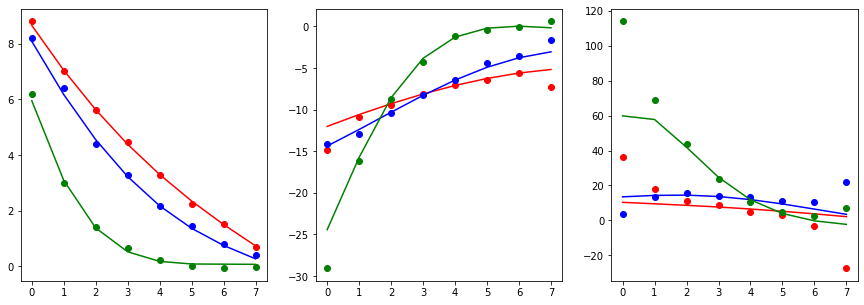

In [36]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3, 1)
plt.plot(output_data[:,800],'ro')
plt.plot(sol[:,800]*np.max(output_data),'r')
plt.plot(output_data[:,400],'bo')
plt.plot(sol[:,400]*np.max(output_data),'b')
plt.plot(output_data[:,100],'go')
plt.plot(sol[:,100]*np.max(output_data),'g')

plt.subplot(1,3, 2)
plt.plot(fd_sg(output_data[:,800],x),'ro')
plt.plot(ux[:,800]*np.max(output_data),'r')
plt.plot(fd_sg(output_data[:,400],x),'bo')
plt.plot(ux[:,400]*np.max(output_data),'b')
plt.plot(fd_sg(output_data[:,100],x),'go')
plt.plot(ux[:,100]*np.max(output_data),'g')

plt.subplot(1,3, 3)
plt.plot(fd_sg(fd_sg(output_data[:,800],x),x),'ro')
plt.plot(uxx[:,800]*np.max(output_data),'r')
plt.plot(fd_sg(fd_sg(output_data[:,400],x),x),'bo')
plt.plot(uxx[:,400]*np.max(output_data),'b')
plt.plot(fd_sg(fd_sg(output_data[:,100],x),x),'go')
plt.plot(uxx[:,100]*np.max(output_data),'g')